In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.ascii 
from astropy import units as u

In [2]:
tab = astropy.io.ascii.read("/Users/huihaoz/Downloads/PS_2023.02.22_19.19.00.csv")

In [3]:
print(tab.colnames)

['pl_name', 'hostname', 'default_flag', 'sy_snum', 'sy_pnum', 'discoverymethod', 'disc_year', 'disc_facility', 'soltype', 'pl_controv_flag', 'pl_refname', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbperlim', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2', 'pl_orbsmaxlim', 'pl_rade', 'pl_radeerr1', 'pl_radeerr2', 'pl_radelim', 'pl_radj', 'pl_radjerr1', 'pl_radjerr2', 'pl_radjlim', 'pl_bmasse', 'pl_bmasseerr1', 'pl_bmasseerr2', 'pl_bmasselim', 'pl_bmassj', 'pl_bmassjerr1', 'pl_bmassjerr2', 'pl_bmassjlim', 'pl_bmassprov', 'pl_orbeccen', 'pl_orbeccenerr1', 'pl_orbeccenerr2', 'pl_orbeccenlim', 'pl_insol', 'pl_insolerr1', 'pl_insolerr2', 'pl_insollim', 'pl_eqt', 'pl_eqterr1', 'pl_eqterr2', 'pl_eqtlim', 'ttv_flag', 'st_refname', 'st_spectype', 'st_teff', 'st_tefferr1', 'st_tefferr2', 'st_tefflim', 'st_rad', 'st_raderr1', 'st_raderr2', 'st_radlim', 'st_mass', 'st_masserr1', 'st_masserr2', 'st_masslim', 'st_met', 'st_meterr1', 'st_meterr2', 'st_metlim', 'st_metratio', 'st_logg', 'st

## calculate contrast and separation

Change: use the new datafile, and from gaia_dist to sy_dist

the number in cal_rad?

In [4]:
np.mean(tab['st_teff'])

5433.8019215270415

In [5]:
tab

pl_name,hostname,default_flag,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,soltype,pl_controv_flag,pl_refname,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_orbsmaxlim,pl_rade,pl_radeerr1,pl_radeerr2,pl_radelim,pl_radj,pl_radjerr1,pl_radjerr2,pl_radjlim,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,pl_bmasselim,pl_bmassj,pl_bmassjerr1,pl_bmassjerr2,pl_bmassjlim,pl_bmassprov,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_orbeccenlim,pl_insol,pl_insolerr1,pl_insolerr2,pl_insollim,pl_eqt,pl_eqterr1,pl_eqterr2,pl_eqtlim,ttv_flag,st_refname,st_spectype,st_teff,st_tefferr1,st_tefferr2,st_tefflim,st_rad,st_raderr1,st_raderr2,st_radlim,st_mass,st_masserr1,st_masserr2,st_masslim,st_met,st_meterr1,st_meterr2,st_metlim,st_metratio,st_logg,st_loggerr1,st_loggerr2,st_logglim,sy_refname,rastr,ra,decstr,dec,sy_dist,sy_disterr1,sy_disterr2,sy_vmag,sy_vmagerr1,sy_vmagerr2,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,rowupdate,pl_pubdate,releasedate
str29,str27,int64,int64,int64,str29,int64,str46,str19,int64,str178,float64,float64,float64,int64,float64,float64,float64,int64,float64,float64,float64,int64,float64,float64,float64,int64,float64,float64,float64,int64,float64,float64,float64,int64,str14,float64,float64,float64,int64,float64,float64,float64,int64,int64,int64,int64,int64,int64,str178,str17,float64,float64,float64,int64,float64,float64,float64,int64,float64,float64,float64,int64,float64,float64,float64,int64,str6,float64,float64,float64,int64,str160,str13,float64,str14,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str10,str7,str10
11 Com b,11 Com,1,2,1,Radial Velocity,2007,Xinglong Station,Published Confirmed,0,<a refstr=LIU_ET_AL__2008 href=https://ui.adsabs.harvard.edu/abs/2008ApJ...672..553L/abstract target=ref> Liu et al. 2008 </a>,326.03,0.32,-0.32,0,1.29,0.05,-0.05,0,--,--,--,--,--,--,--,--,6165.6,476.7,-476.7,0,19.4,1.5,-1.5,0,Msini,0.231,0.005,-0.005,0,--,--,--,--,--,--,--,--,0,<a refstr=LIU_ET_AL__2008 href=https://ui.adsabs.harvard.edu/abs/2008ApJ...672..553L/abstract target=ref> Liu et al. 2008 </a>,G8 III,4742.0,100.0,-100.0,0,19.0,2.0,-2.0,0,2.7,0.3,-0.3,0,-0.35,0.09,-0.09,0,[Fe/H],2.31,0.1,-0.1,0,<a refstr=STASSUN_ET_AL__2019 href=https://ui.adsabs.harvard.edu/abs/2019AJ....158..138S/abstract target=ref>TICv8</a>,12h20m42.91s,185.1787793,+17d47m35.71s,17.7932516,93.1846,1.9238,-1.9238,4.72307,0.023,-0.023,2.282,0.346,-0.346,4.44038,0.0038479,-0.0038479,2014-05-14,2008-01,2014-05-14
11 UMi b,11 UMi,1,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,0,<a refstr=STASSUN_ET_AL__2017 href=https://ui.adsabs.harvard.edu/abs/2017AJ....153..136S/abstract target=ref>Stassun et al. 2017</a>,516.21997,3.2,-3.2,0,1.53,0.07,-0.07,0,--,--,--,--,--,--,--,--,4684.8142,794.575,-794.575,0,14.74,2.5,-2.5,0,Msini,0.08,0.03,-0.03,0,--,--,--,--,--,--,--,--,0,<a refstr=STASSUN_ET_AL__2017 href=https://ui.adsabs.harvard.edu/abs/2017AJ....153..136S/abstract target=ref>Stassun et al. 2017</a>,--,4213.0,46.0,-46.0,0,29.79,2.84,-2.84,0,2.78,0.69,-0.69,0,-0.02,--,--,0,[Fe/H],1.93,0.07,-0.07,0,<a refstr=STASSUN_ET_AL__2019 href=https://ui.adsabs.harvard.edu/abs/2019AJ....158..138S/abstract target=ref>TICv8</a>,15h17m05.90s,229.2745954,+71d49m26.19s,71.8239428,125.321,1.9765,-1.9765,5.013,0.005,-0.005,1.939,0.27,-0.27,4.56216,0.0039035,-0.0039035,2018-09-04,2017-03,2018-09-06
14 And b,14 And,1,1,1,Radial Velocity,2008,Okayama Astrophysical Observatory,Published Confirmed,0,<a refstr=SATO_ET_AL__2008 href=https://ui.adsabs.harvard.edu/abs/2008PASJ...60.1317S/abstract target=ref> Sato et al. 2008 </a>,185.84,0.23,-0.23,0,0.83,--,--,0,--,--,--,--,--,--,--,--,1525.5,--,--,0,4.8,--,--,0,Msini,0.0,--,--,0,--,--,--,--,--,--,--,--,0,<a refstr=SATO_ET_AL__2008 href=https://ui.adsabs.harvard.edu/abs/2008PASJ...60.1317S/abstract target=ref> Sato et al. 2008 </a>,K0 III,4813.0,20.0,-20.0,0,11.0,1.

In [6]:
tab['dec']<0

array([False, False, False, ..., False,  True, False])

In [7]:
contrast_arr = np.zeros((len(tab)))
sma_arr = np.zeros((len(tab)))
sep_arr = np.zeros((len(tab)))
rad_arr = np.zeros((len(tab)))
dis_arr = np.zeros((len(tab)))

def cal_rad(mass):
    if mass < (2.0 * u.earthMass):
        rad = (((mass / (1.0 * u.earthMass)).decompose())**(0.28) * u.earthRad).to(u.jupiterRad)
    elif mass < (0.41 * u.jupiterMass):
        rad = (((mass / (14.5 * u.earthMass)).decompose())**(0.59) * (4.01 * u.earthRad)).to(u.jupiterRad)
    elif mass < (0.08 * u.solMass):
        rad = ((mass / (1 * u.jupiterMass)).decompose())**(-0.04) * (1.1 * u.jupiterRad)
    else:
        rad = ((mass / (0.08 * u.solMass)).decompose())**(0.88) * (0.95 * u.jupiterRad) 
    return(rad)

k = 0
for i, tmp in enumerate(tab["pl_name"]):
    if tab["pl_orbper"].mask[i] == False:
        # calculating sma
        if tab["pl_orbsmax"].mask[i] == True:
            if tab["st_mass"].mask[i] == True:
                sma = ((tab["pl_orbper"][i] / 365.0)**2 * 1.0)**(0.33) * u.AU
            else:
                sma = ((tab["pl_orbper"][i] / 365.0)**2 * tab["st_mass"][i])**(0.33) * u.AU
        else:
            sma = tab["pl_orbsmax"][i] * u.AU

        # calculating angular separation
        if tab["sy_dist"].mask[i] == True:
            if tab["sy_dist"].mask[i] == True:
                dis = 999 * u.parsec
            else:
                dis = tab["sy_dist"][i] * u.parsec
        else:
            dis = tab["sy_dist"][i] * u.parsec
        sep = ((sma / dis).decompose() * u.radian).to(u.arcsec)

        # calculating planet radius, https://arxiv.org/pdf/1603.08614.pdf
        if tab["pl_radj"].mask[i] == True:
            if tab["pl_bmassj"].mask[i] == False:
                mass = tab["pl_bmassj"][i] * u.jupiterMass
                rad = cal_rad(mass)
            else:
                rad = 1.0 * u.jupiterRad
        else:
            rad = tab["pl_radj"][i] * u.jupiterRad
            
        # calculating contrast
        albedo = 0.3
        con = ((rad / sma).decompose())**2 * albedo


        if (con > 1e-7) & (sep.value > 5e-3) & (tab["dec"][i] > -100.0) & (rad < (0.2 * u.jupiterRad)):
#             print(tab["pl_name"][i], tab["pl_orbper"][i], sma.value, tab["pl_bmassj"][i], rad.value, \
#                   dis.value, tab["st_teff"][i], tab["st_mass"][i], con, sep.value, tab["dec"][i], \
#                   tab["st_k"][i], tab["st_wise1"][i])
            k = k + 1
#         elif tab["pl_name"][i] == "Ross 128 b":
#              print(tab["pl_name"][i], tab["pl_orbper"][i], sma.value, tab["pl_bmassj"][i], rad.value, \
#                   dis.value, tab["st_teff"][i], tab["st_mass"][i], con, sep.value, tab["dec"][i])           
        else:
            1 == 1

        sma_arr[i] = sma.value
        sep_arr[i] = sep.value
        rad_arr[i] = rad.value
        contrast_arr[i] = con
        dis_arr[i] = dis.value
    else:
        sma_arr[i] = 1.0
        sep_arr[i] = 1e-5
        rad_arr[i] = 1.0
        contrast_arr[i] = 1e-10       
        dis_arr[i] = 1e3

In [8]:
sep = ((sma / dis).decompose() * u.radian).to(u.arcsec)

## Plot seleted targets

Only changed lambda_D,

1$\mu$m to 2$\mu$m, 30 m to 39.3 m

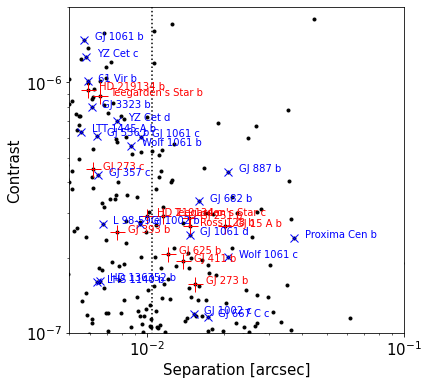

In [9]:
con_threshold = 1e-7
sep_threshold = 5e-3
rad_threshold = 0.2

plt.figure(figsize=(6,6))

font_size = 15

plt.plot(sep_arr, contrast_arr, 'k.')

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Separation [arcsec]", fontsize=font_size)
plt.ylabel("Contrast", fontsize=font_size)
plt.gca().tick_params(labelsize=font_size)
plt.xlim(5e-3, 1e-1)
plt.ylim(1e-7, 2e-6)


lambda_D = (((2.0 * u.micron) / (39.3 * u.meter).decompose()) * u.radian).to(u.arcsec)
plt.vlines(lambda_D.value, 1e-10, 1e-5, color="black", linestyle="dotted")

# lambda_D = (((2.0 * u.micron) / (22.4 * u.meter).decompose()) * u.radian).to(u.arcsec)
# plt.vlines(lambda_D.value, 1e-10, 1e-5, color="blue", linestyle="dashed")

# plt.hlines(5e-7, 1e-3, 1e-1, color="k", linestyle="solid")

ind = np.where((contrast_arr > con_threshold) & (sep_arr > sep_threshold) & (rad_arr < 0.2))
rot_arr = np.zeros((len(contrast_arr[ind]), ))
for ii, i in enumerate(np.array(ind).flatten()):
    if (tab["dec"][i] > 0.0):
        plt.plot(sep_arr[i], contrast_arr[i], color="r", ms=15, marker="+")
        plt.annotate(tab["pl_name"][i], xy=(sep_arr[i] * 1.1, contrast_arr[i]), rotation=rot_arr[ii], color="red")
    else:
        plt.plot(sep_arr[i], contrast_arr[i], color="b", ms=8, marker="x")
        plt.annotate(tab["pl_name"][i], xy=(sep_arr[i] * 1.1, contrast_arr[i]), rotation=rot_arr[ii], color="blue")




In [10]:
temp = [183.707, 224.199, 365.493, 319.321, 266.145, 355.467, 306.961, 240.079, 258.630, 427.655, 217.185, 282.712, 201.836, 275.106]
temp = [230.9,182,278.48206,224,240,259,468,217,423.81807,275]

In [11]:
rad_arr[ind]**2 * 100000

array([3716.98865454,  831.23508608,  945.59285816,  949.29882663,
       1084.84720779, 1049.97632267, 2016.783496  , 2801.30255565,
       1907.37039786,  872.86094533, 1251.43717645, 2312.07817206,
       1074.81507024, 1752.37352961, 3953.86274338, 1853.01752781,
       2647.05842061, 3132.34970684, 2964.79712436, 2190.4       ,
       2044.9       , 1822.5       , 2041.77872752, 2131.6       ,
       1345.6       ,  827.11979992,  960.34918381,  817.45429331,
        843.48606451, 1143.57690784, 2319.72940614,  856.93634727,
        835.33442596])

In [12]:
(((rad_arr[ind]- np.mean(rad_arr[ind]))/ np.std(rad_arr[ind]))) * 100 + 140

array([343.07407464,  25.42493906,  44.3967844 ,  44.99183115,
        66.00957456,  60.73438801, 184.34324356, 263.60458283,
       172.13424982,  32.47332917,  90.11439479, 215.73120969,
        64.50073492, 154.2225679 , 361.97960704, 165.93899955,
       248.99759725, 293.65422747, 278.6549561 , 203.05562845,
       187.42680238, 162.42068068, 187.08554047, 196.80409802,
       103.03114162,  24.71861664,  46.75926361,  23.05274655,
        27.51733459,  74.70594297, 216.51698384,  29.79713988,
        26.1267884 ])

In [13]:
(rad_arr[ind]*u.R_jupiter).to(u.R_earth)

<Quantity [2.1610347 , 1.02194625, 1.08997921, 1.09211304, 1.16748258,
           1.14856579, 1.59182662, 1.87605744, 1.54804522, 1.04722175,
           1.25392237, 1.70438373, 1.16207189, 1.483814  , 2.22882986,
           1.52582908, 1.82367685, 1.98381534, 1.93002801, 1.65892915,
           1.60288424, 1.5132124 , 1.60166048, 1.63651119, 1.30024176,
           1.01941338, 1.09845105, 1.01343958, 1.02944957, 1.19866772,
           1.70720151, 1.03762495, 1.02446308] earthRad>

In [14]:
lambda_D.to(u.mas)

<Quantity 10.4969367 mas>

In [15]:
tab["pl_name","pl_bmasse","pl_rade","pl_orbsmax","sy_dist","st_logg","st_teff"][ind]

pl_name,pl_bmasse,pl_rade,pl_orbsmax,sy_dist,st_logg,st_teff
str29,float64,float64,float64,float64,float64,float64
61 Vir b,5.1,--,0.050201,8.50332,4.34,5577.0
GJ 1002 b,1.08,--,0.0457,4.84867,5.1,3024.0
GJ 1002 c,1.36,--,0.0738,4.84867,5.1,3024.0
GJ 1061 b,1.37,--,0.021,3.67278,--,2953.0
GJ 1061 c,1.74,--,0.035,3.67278,--,2953.0
GJ 1061 d,1.64,--,0.054,3.67278,--,2953.0
GJ 15 A b,3.03,--,0.072,3.56228,4.87,3607.0
GJ 251 b,4.0,--,0.0818,5.58057,4.96,3451.0
GJ 273 b,2.89,--,0.091101,5.921535,--,3382.0


In [16]:
lambda_D = (((3.0 * u.micron) / (39.3 * u.meter).decompose()) * u.radian).to(u.arcsec)
lambda_D.to(u.mas)

<Quantity 15.74540506 mas>

In [17]:
ind

(array([  33,  173,  174,  175,  176,  177,  187,  202,  204,  205,  220,
         230,  237,  241,  254,  258,  261,  271,  286,  585,  872,  873,
        4546, 4547, 4560, 4734, 4748, 4985, 4986, 5189, 5190, 5204, 5205]),)

In [18]:
#temp = [183.707, 224.199, 365.493, 319.321, 266.145, 355.467, 306.961, 240.079, 258.630, 427.655, 217.185, 282.712, 201.836, 275.106]

In [19]:
ind[0][-3]

5190

In [20]:
ind = np.where((contrast_arr > con_threshold) & (sep_arr > sep_threshold) & (rad_arr < 0.2) & (tab['dec']<0))

In [21]:
lambda_D.to(u.mas)

<Quantity 15.74540506 mas>

In [22]:
lambda_D2.to(u.mas)

NameError: name 'lambda_D2' is not defined

In [23]:
lambda_D.to(u.mas)

<Quantity 15.74540506 mas>

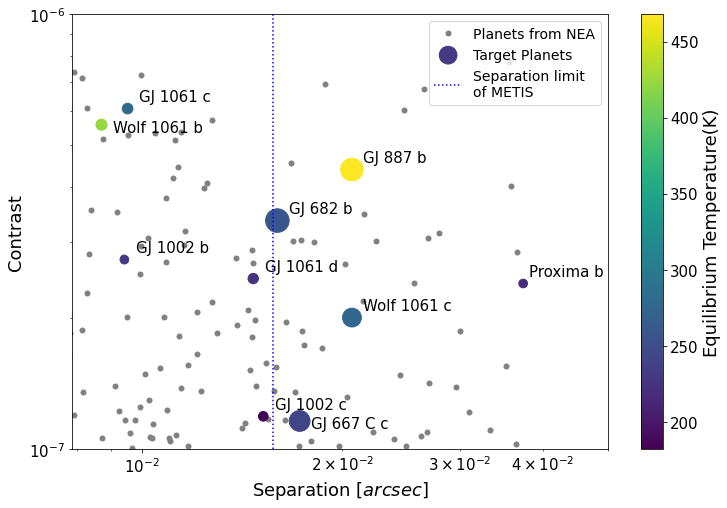

In [26]:
lambda_D = (((1.5 * u.micron) / (39.3 * u.meter).decompose()) * u.radian).to(u.arcsec)
lambda_D2 = (((3 * u.micron) / (39.3 * u.meter).decompose()) * u.radian).to(u.arcsec)
lambda_D3 = (((2.5 * u.micron) / (39.3 * u.meter).decompose()) * u.radian).to(u.arcsec)

con_threshold = 1e-7
sep_threshold = lambda_D.value
rad_threshold = 0.2
fig, ax = plt.subplots(figsize=(12, 8))

font_size = 18

ind = np.where((contrast_arr > con_threshold) & (sep_arr > sep_threshold) & (rad_arr < 0.2) & (tab['dec'] < 0.0))
tab["pl_name"][ind[0][-3]] = 'Proxima b'
ind2 = np.where( (tab[ind]['dec'] < 0.0) )
rot_arr = np.zeros((len(contrast_arr[ind]), ))
#for ii, i in enumerate(np.array(ind).flatten()):
#    if (tab["dec"][i] > 0.0):
#        plt.annotate(tab["pl_name"][i], xy=(sep_arr[i] * 1.04, contrast_arr[i] * 1.04), rotation=0, color="black",size=15)
#    else:
#        plt.annotate(tab["pl_name"][i], xy=(sep_arr[i] * 1.04, contrast_arr[i] * 1.04), rotation=0, color="black",size=15)
plt.annotate(tab["pl_name"][ind[0][0]], xy=(sep_arr[ind[0][0]] * 1.04, contrast_arr[ind[0][0]] * 1.04), rotation=0, color="black",size=15)
plt.annotate(tab["pl_name"][ind[0][1]], xy=(sep_arr[ind[0][1]] * 1.04, contrast_arr[ind[0][1]] * 1.04), rotation=0, color="black",size=15)
plt.annotate(tab["pl_name"][ind[0][2]], xy=(sep_arr[ind[0][2]] * 1.04, contrast_arr[ind[0][2]] * 1.04), rotation=0, color="black",size=15)
plt.annotate(tab["pl_name"][ind[0][3]], xy=(sep_arr[ind[0][3]] * 1.04, contrast_arr[ind[0][3]] * 1.04), rotation=0, color="black",size=15)
plt.annotate(tab["pl_name"][ind[0][4]], xy=(sep_arr[ind[0][4]] * 1.04, contrast_arr[ind[0][4]] * 0.96), rotation=0, color="black",size=15)
plt.annotate(tab["pl_name"][ind[0][5]], xy=(sep_arr[ind[0][5]] * 1.04, contrast_arr[ind[0][5]] * 1.04), rotation=0, color="black",size=15)
plt.annotate(tab["pl_name"][ind[0][6]], xy=(sep_arr[ind[0][6]] * 1.04, contrast_arr[ind[0][6]] * 1.04), rotation=0, color="black",size=15)
plt.annotate(tab["pl_name"][ind[0][7]], xy=(sep_arr[ind[0][7]] * 1.02, contrast_arr[ind[0][7]] * 1.04), rotation=0, color="black",size=15)
plt.annotate(tab["pl_name"][ind[0][8]], xy=(sep_arr[ind[0][8]] * 1.04, contrast_arr[ind[0][8]] * 0.96), rotation=0, color="black",size=15)
plt.annotate(tab["pl_name"][ind[0][9]], xy=(sep_arr[ind[0][9]] * 1.04, contrast_arr[ind[0][9]] * 1.04), rotation=0, color="black",size=15)
plt.plot(sep_arr, contrast_arr, 'o',color="grey",ms=5,label="Planets from NEA",zorder=-1)

sc =plt.scatter(sep_arr[ind], contrast_arr[ind],s=rad_arr[ind]**3 * 100000, c=temp,label="Target Planets",zorder=1)
cbar = plt.colorbar(sc)
cbar.ax.tick_params(labelsize=15)
cbar.set_label('Equilibrium Temperature(K)',size=18)
fig.patch.set_facecolor('white')
plt.vlines(lambda_D2.value, 1e-7, 1e-6, color="blue", linestyle="dotted",label = 'Separation limit \nof METIS')
#plt.vlines(lambda_D3.value, 1e-7, 1e-6, color="black", linestyle="dotted")
plt.legend( prop={'size': 14},loc='upper right')
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r'Separation [$arcsec$]', fontsize=font_size)
plt.ylabel(r'Contrast', fontsize=font_size)
plt.xlim(lambda_D.value, 0.5e-1)
plt.ylim(1e-7, 1e-6)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)


In [22]:
(3+5.6)/2

4.3

In [179]:
enumerate(np.array(ind).flatten())

In [180]:
tab[""][ind]

KeyError: ''

In [181]:
tab["pl_name"][ind]

GJ 1002 b
GJ 1002 c
GJ 1061 c
GJ 1061 d
GJ 667 C c
GJ 682 b
GJ 887 b
Proxima b
Wolf 1061 b
Wolf 1061 c


In [182]:
tab["st_rad"][ind] * u.solRad

<Quantity [0.14, 0.14, 0.16, 0.16, 0.  , 0.  , 0.47, 0.14, 0.31, 0.31] solRad>

In [183]:
(((tab["st_rad"][ind] * u.solRad)/ (u.AU * 2 *  tab["pl_orbsmax"][ind]))**(1/2) * (1-0.3)**(0.25)).to(u.m/u.m) * tab["st_teff"][ind] * u.k

<Quantity [233.45087844, 183.70688433, 278.48206069, 224.19935881,
             0.        ,   0.        , 427.65464432, 217.18532874,
           423.81806707, 275.10602193] k>

In [184]:
tab["pl_orbsmax"][ind]

0.0457
0.0738
0.035
0.054
0.125
0.08
0.068
0.04856
0.0375
0.089


In [185]:
tab["pl_name"][ind]

GJ 1002 b
GJ 1002 c
GJ 1061 c
GJ 1061 d
GJ 667 C c
GJ 682 b
GJ 887 b
Proxima b
Wolf 1061 b
Wolf 1061 c


In [186]:
temp = [230.9,182,278.48206,224,240,259,468,217,423.81807,275]

In [187]:
tab["pl_name"][ind]

GJ 1002 b
GJ 1002 c
GJ 1061 c
GJ 1061 d
GJ 667 C c
GJ 682 b
GJ 887 b
Proxima b
Wolf 1061 b
Wolf 1061 c


In [188]:
(((sep_arr[ind]*u.arcsec).to(u.radian) / u.radian) * 39.3*u.meter).to(u.micron)

<Quantity [1.7958125 , 2.90002106, 1.81568517, 2.80134284, 3.28776968,
           3.04442281, 3.9380428 , 7.11058575, 1.65932986, 3.93814286] micron>

In [189]:
lambda_D3 = (((2.45 * u.micron) / (39.3 * u.meter).decompose()) * u.radian).to(u.arcsec)

In [94]:
((2.45 * u.micron) / (39.3 * u.meter).decompose()) * u.radian

<Quantity 0.06234097 micron rad / m>

In [ ]:
lambda_D2

In [ ]:
rot_arr

In [ ]:
def cal_rad(mass):
    if mass < (2.0 * u.earthMass):
        rad = (((mass / (1.0 * u.earthMass)).decompose())**(0.28) * u.earthRad).to(u.R_earth)
    elif mass < ((0.41 * u.jupiterMass).to(u.earthMass)):
        rad = (((mass / (14.5 * u.earthMass)).decompose())**(0.59) * (4.01 * u.earthRad)).to(u.R_earth)
    elif mass < ((0.08 * u.solMass).to(u.earthMass)):
        rad = (((mass / (1 * u.jupiterMass)).decompose())**(-0.04) * (1.1 * u.jupiterRad)).to(u.R_earth)
    else:
        rad = (((mass / (0.08 * u.solMass)).decompose())**(0.88) * (0.95 * u.jupiterRad)).to(u.R_earth)
    return(rad)


set i = 90

In [ ]:
ind = np.where((contrast_arr > con_threshold) & (sep_arr > sep_threshold) & (rad_arr < 0.2))
rot_arr = np.zeros((len(contrast_arr[ind]), ))
for ii, i in enumerate(np.array(ind).flatten()):
    if (tab["dec"][i] > 0.0):
        print(tab["pl_name"][i],tab["pl_bmasse"][i],cal_rad(tab["pl_bmasse"][i]*u.earthMass),tab["pl_orbsmax"][i],tab["sy_dist"][i],tab["st_rad"][i],tab["st_logg"][i],tab["st_teff"][i])
    else:
        print(tab["pl_name"][i],tab["pl_bmasse"][i],cal_rad(tab["pl_bmasse"][i]*u.earthMass), tab["pl_orbsmax"][i],tab["sy_dist"][i],tab["st_rad"][i],tab["st_logg"][i],tab["st_teff"][i])

In [ ]:
cal_rad(1)

In [ ]:
tab["pl_bmasse"]*u.earthMass

In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv('/Users/huihaoz/Documents/reseatch/PT_PES.txt', sep=",")

In [ ]:
data